In [1]:
%cd ..

D:\anomaly-detection


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

import cufflinks as cf
cf.go_offline(connected=True)

import bokeh.io
bokeh.io.output_notebook()

from src.visualization.visualize import ratios_plot

Loading BokehJS ...

# Preparing data

In [3]:
ratios = np.load('result/TEP_small-ratios.npy')

In [4]:
peaksP, _ = find_peaks(ratios, distance=100, prominence=1)
peaksN, _ = find_peaks(-ratios, distance=100, prominence=1.5)
peaks = sorted(np.concatenate((peaksP, peaksN), axis=0))

In [5]:
to_remove = []
for i, peak in enumerate(peaks):
    if np.isclose(ratios[peak + 100], ratios[peak - 100]) and np.isclose(
            ratios[peak + 100], ratios[peak]):
        to_remove.append(i)

for i in reversed(to_remove):
    peaks.pop(i)

peaks = np.array(peaks)

In [6]:
ratios_plot(ratios, peaks)

In [7]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [8]:
boundaries = [0, *list(peaks), ratios.shape[0]]

X = []
for left, right in zip(boundaries[:-1], boundaries[1:]):
    X.append(data.iloc[left:right].values)

In [9]:
from sklearn.model_selection import train_test_split
X_tr, X_te = train_test_split(X, train_size=0.75)

In [10]:
from tslearn.utils import to_time_series_dataset
X_dataset = to_time_series_dataset(X_tr + X_te)
X_tr_dataset = X_dataset[:len(X_tr)]
X_te_dataset = X_dataset[len(X_tr):]

# Clustering

In [13]:
def cluster_plot(labels):
    mx_row = np.max(np.bincount(labels))
    mx_col = np.max(labels) + 1

    plt.figure(figsize=(8 * mx_col, 6 * mx_row))
    for col in range(mx_col):
        idxs = np.where(labels == col)[0]
        for i in range(len(idxs)):
            plt.subplot(mx_row, mx_col, mx_col * i + col + 1)
            if i == 0:
                plt.title(str(col))
            plt.plot(data.iloc[boundaries[idxs[i]]:boundaries[idxs[i] + 1]])
            rng = list(range(boundaries[idxs[i]], boundaries[idxs[i] + 1]))
            step = len(rng) // 6
            plt.xticks(rng[::step])

## GlobalAlignmentKernelKMeans

In [11]:
from tslearn.clustering import GlobalAlignmentKernelKMeans
gak_km = GlobalAlignmentKernelKMeans(n_clusters=4)
labels_gak = gak_km.fit_predict(X_tr_dataset)

C:\Anaconda3\envs\anom-det\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.



In [17]:
gak_km.predict(X_te_dataset)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

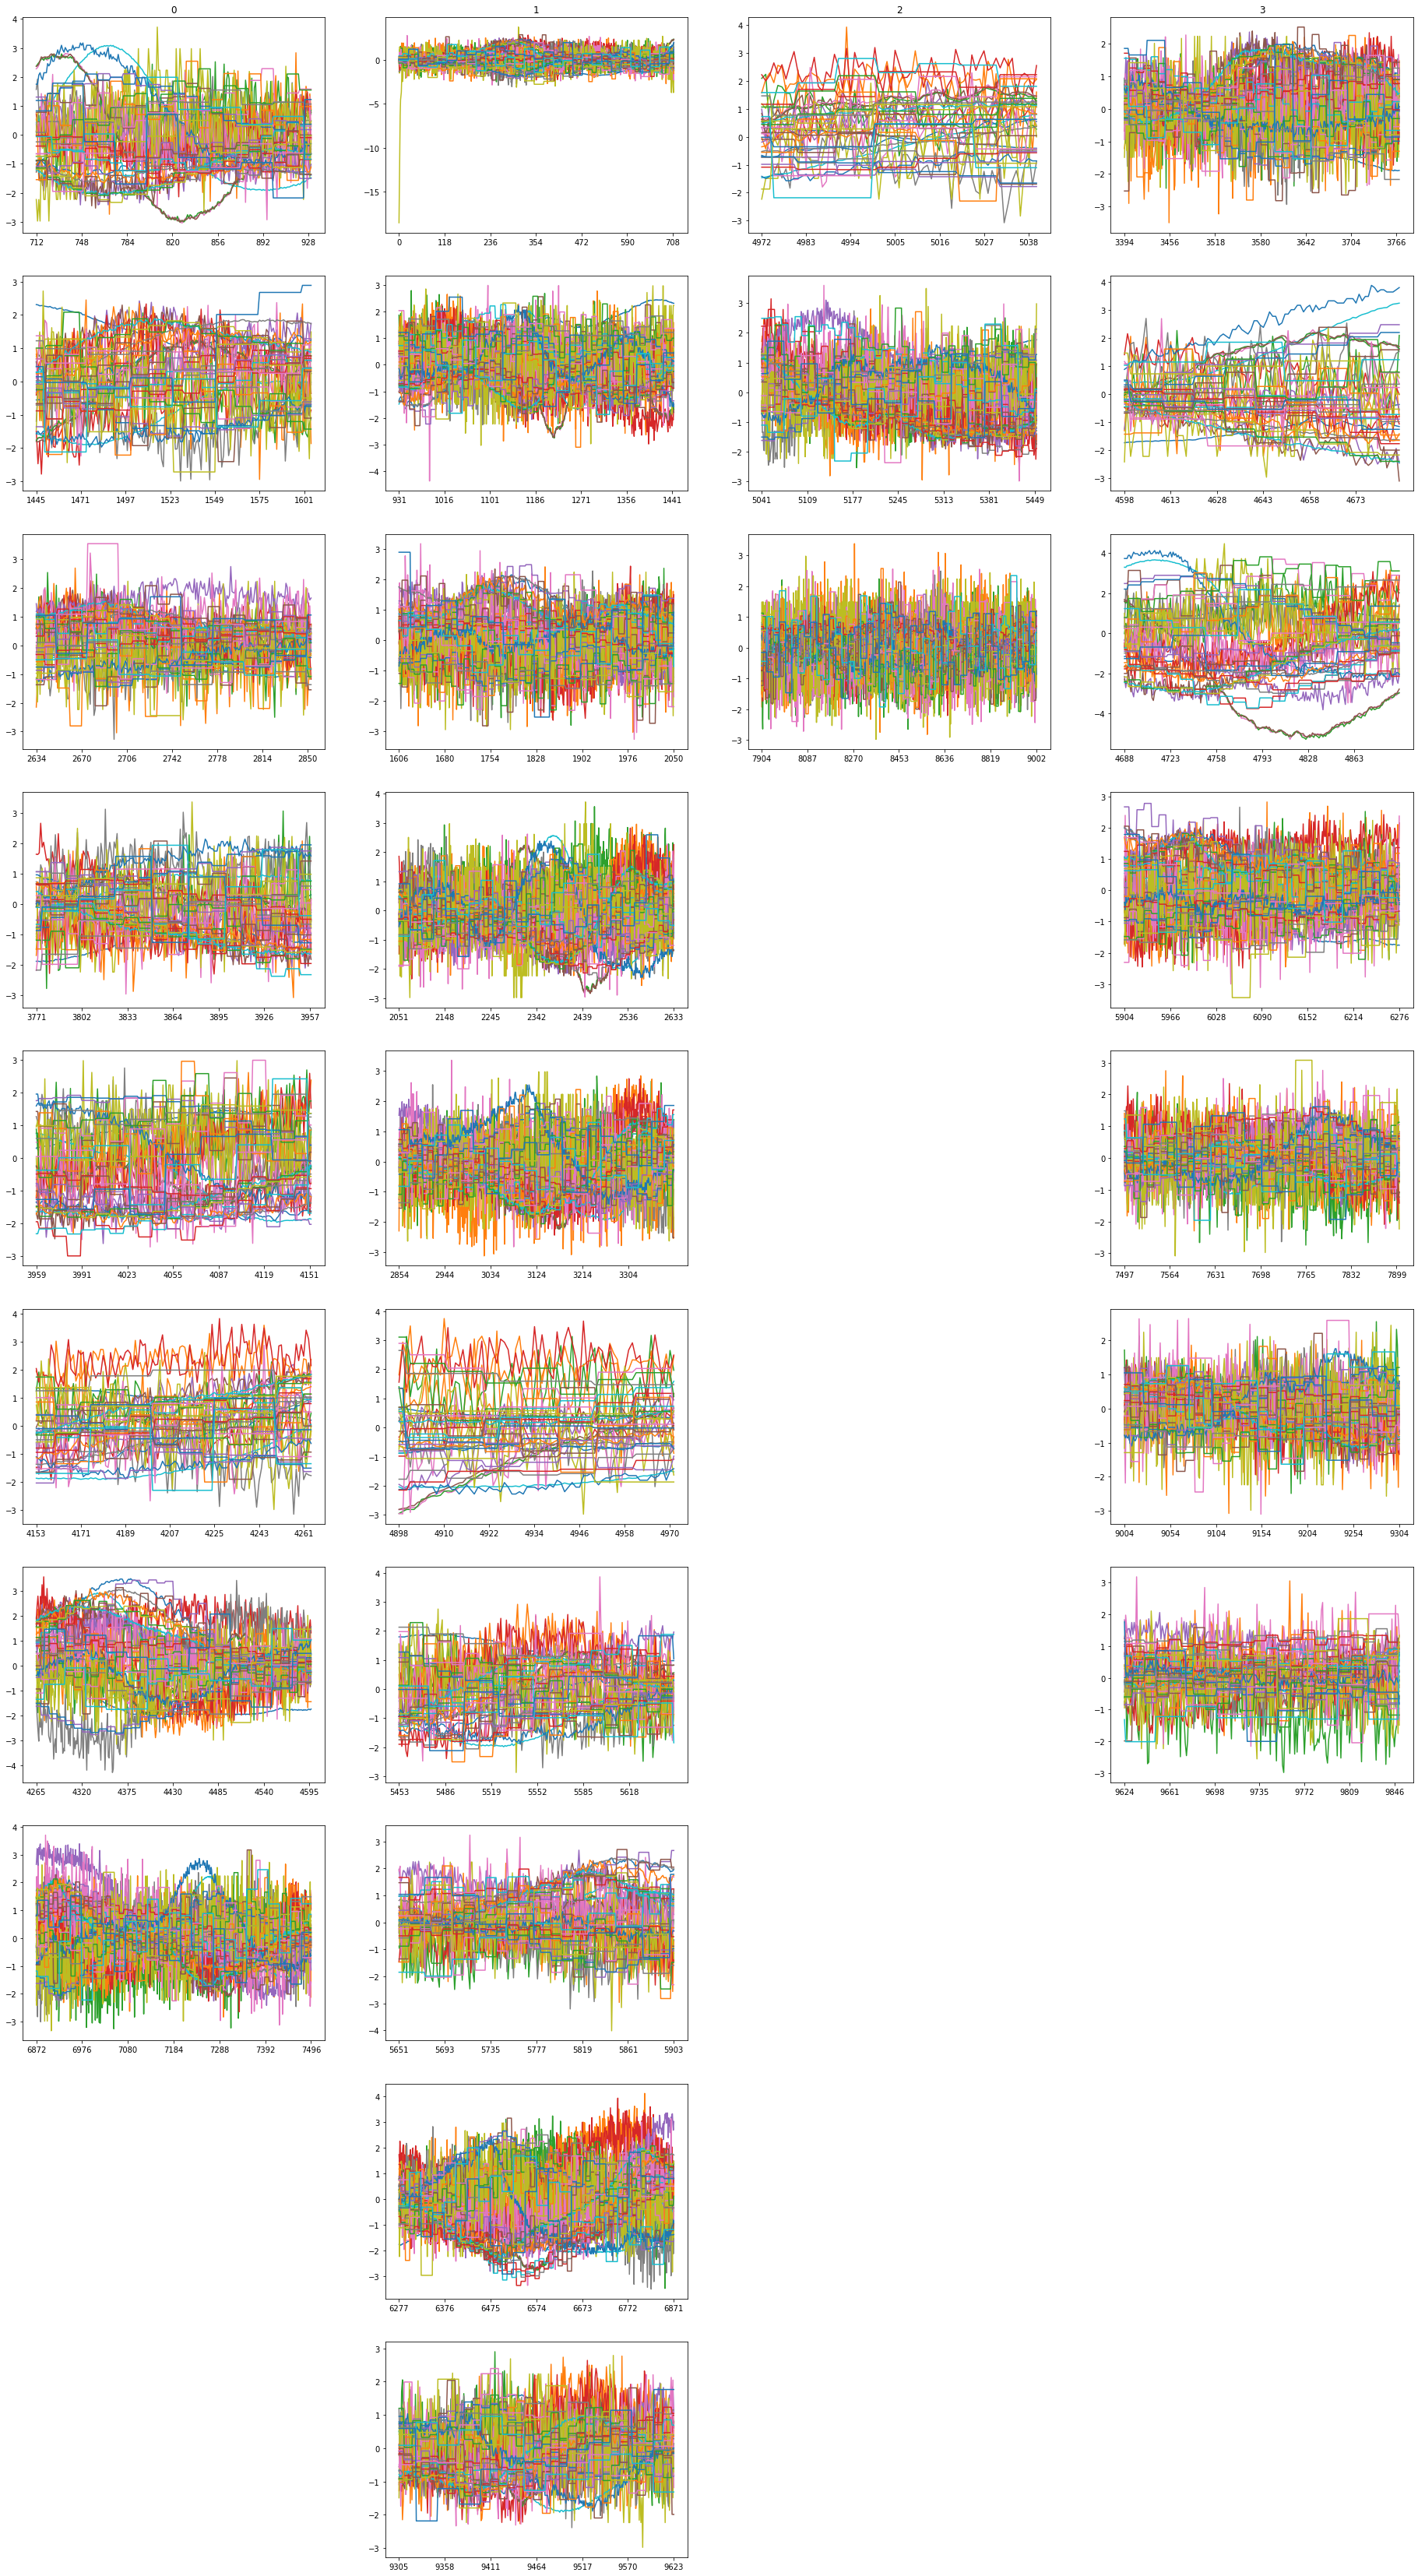

In [14]:
cluster_plot(labels_gak)

In [15]:
np.bincount(labels_gak)

array([ 8, 10,  3,  7], dtype=int64)

## TSKMeans with dtw

In [18]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
km = TimeSeriesKMeans(n_clusters=4, metric="dtw")
labels_ts_km = km.fit_predict(X_tr_dataset)
# silhouette_score(X_tr_dataset, labels_ts_km, metric="dtw")

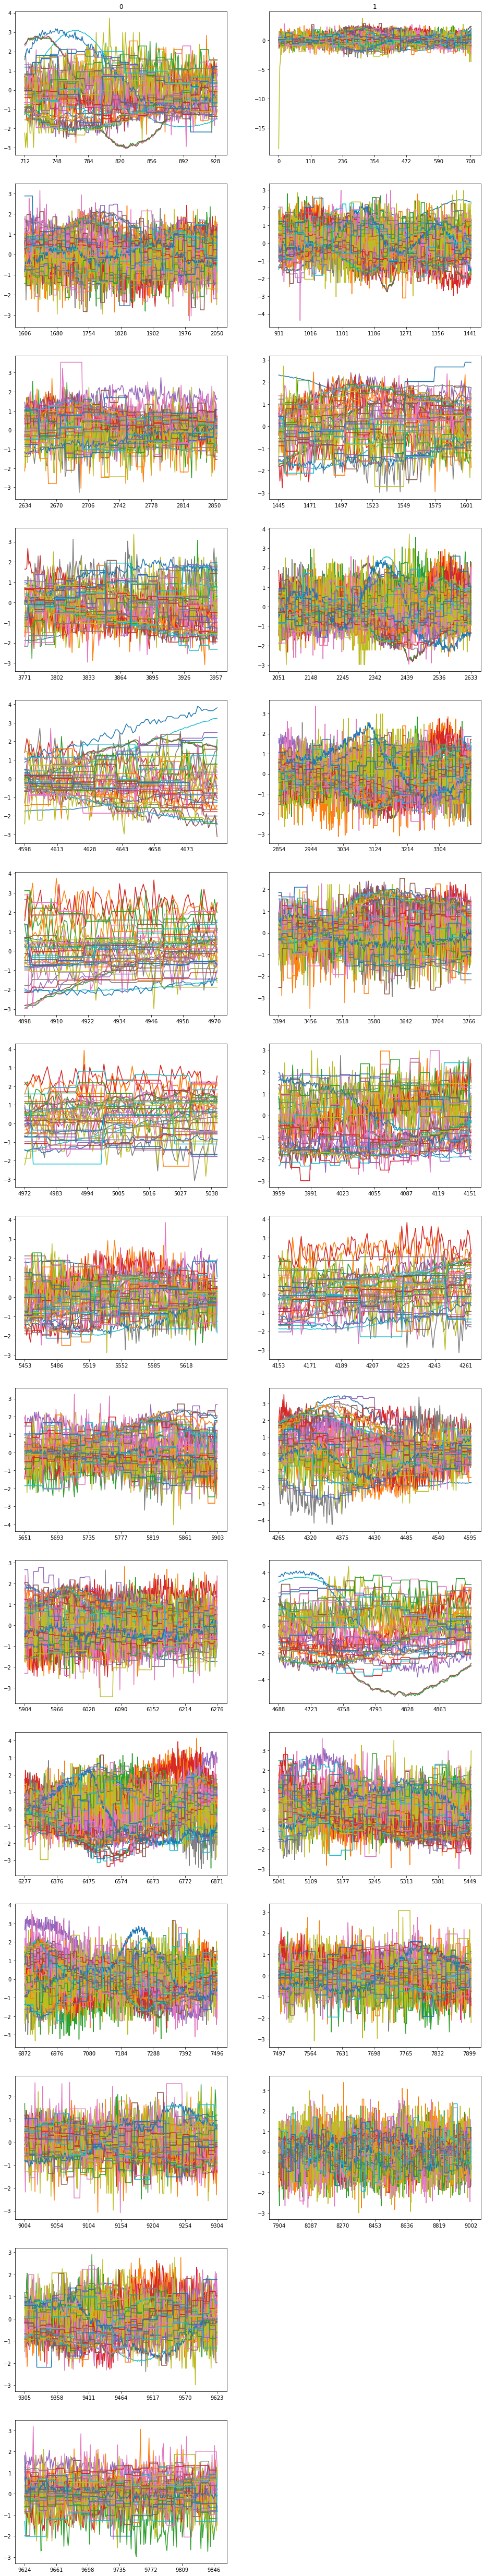

In [19]:
cluster_plot(labels_ts_km)

In [20]:
np.bincount(labels_ts_km)

array([15, 13], dtype=int64)

# Compare

## Clusterization

In [11]:
from sklearn.model_selection import train_test_split
import keras

from src.models.lstm import lstm_model, fit_generator
from src.features.build_features import rolling_window


prediction_len = 2
window_len = 64
batch_size = 64

Using TensorFlow backend.


In [12]:
def validation_generator(X, y, batch_size=64):
    assert len(X) == len(y)
    while True:
        for i in range(0, len(X), batch_size):
            yield np.array(X[i:i+batch_size]), np.array(y[i:i+batch_size])

In [13]:
def samples_from_cluster(X_cluster, prediction_len, window_len):
    """
    Returns shuffled rolling windows from cluster samples
    """
    X_samples, y_samples = [], []
    for sample in X_cluster:
        X_samples.extend(rolling_window(sample[:-prediction_len], window_len))
        y_samples.extend(rolling_window(sample, window_len, prediction_len))

    idxs = list(range(len(X_samples)))
    np.random.shuffle(idxs)
    X_samples = np.take(X_samples, idxs, axis=0)
    y_samples = np.take(y_samples, idxs, axis=0)

    return X_samples, y_samples

In [14]:
def evaluate_clusterization(model, name):
    tr_lables = model.fit_predict(X_tr_dataset)
    te_labels = model.predict(X_te_dataset)
    
    print(np.bincount(tr_lables))
    print(np.bincount(te_labels))
    
    for cluster in np.unique(tr_lables):
        X_tr_cluster = np.take(X_tr,
                               np.nonzero(tr_lables == cluster)[0],
                               axis=0)
        
        if np.nonzero(te_labels == cluster)[0].shape[0] == 0:
            continue
        X_te_cluster = np.take(X_te,
                               np.nonzero(te_labels == cluster)[0],
                               axis=0)

        X_tr_samples, y_tr_samples = samples_from_cluster(X_tr_cluster, prediction_len, window_len)
        X_te_samples, y_te_samples = samples_from_cluster(X_te_cluster, prediction_len, window_len)

        model = lstm_model(**params)

        fit_params['callbacks'][2] = keras.callbacks.TensorBoard(
            log_dir="logs/clusters_" + name + "/" + str(cluster),
            update_freq='batch')
        fit_params['callbacks'][3] = keras.callbacks.ModelCheckpoint(
            filepath='models/clusters_' + name + '/' + str(cluster) + '.h5',
            save_best_only=True)

        model.fit_generator(
            generator=fit_generator(X_tr_samples, y_tr_samples, batch_size),
            steps_per_epoch=len(X_tr_samples) // batch_size,
            validation_data=validation_generator(X_te_samples, y_te_samples,
                                                 batch_size),
            validation_steps=(len(X_te_samples) + batch_size - 1) //
            batch_size,
            **fit_params)

In [15]:
class Clusterization:
    """
    Clusterization followed by classifier by gotten labels
    """
    def __init__(self, cluster_model, classifier_model):
        self.cluster_model = cluster_model
        self.classifier_model = classifier_model
        
    def fit(self, X):
        self.train_labels = self.cluster_model.fit_predict(X)
        nunique = np.bincount(self.train_labels).shape[0]
        self.classifier_model.fit(X, self.train_labels)
        
    def predict(self, X):
        return self.classifier_model.predict(X)
        
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

In [16]:
# from tslearn.svm import TimeSeriesSVC
# from tslearn.utils import to
# clf = TimeSeriesSVC(C=1.0, kernel="gak")
# clf.fit(X_tr_dataset.copy(), labels_gak)

# print(np.bincount(clf.predict(X_te_dataset.copy())))

In [17]:
params = dict(
    input_length=window_len,
    input_shape=data.shape[1],
    lstm_layers_size=[16],
#     dropout_coeff=0.1,
    loss='mse',
    optimizer=keras.optimizers.Adam(lr=0.02),
    reg_strength=0.005,
)

fit_params = dict(
    epochs=40,
    verbose=1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=3, min_delta=0.005, factor=0.5),
        keras.callbacks.EarlyStopping(min_delta=0.01, patience=9),
        None, # Tensorboard
        None, # Model checkpoint
    ]
)

In [18]:
# [10  8  7  3]
# [2 3 3 2]

In [19]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.clustering import GlobalAlignmentKernelKMeans

clusterization_1 = Clusterization(
    GlobalAlignmentKernelKMeans(n_clusters=4, max_iter=100, n_jobs=2),
    KNeighborsTimeSeriesClassifier(n_neighbors=3, n_jobs=2)
)

evaluate_clusterization(
    clusterization_1, 
    'gak-knn')

C:\Anaconda3\envs\anom-det\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

C:\Anaconda3\envs\anom-det\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.



[7 9 8 4]
[2 2 4 2]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/40
 1/28 [>.............................] - ETA: 11s - loss: 1.3668WARNING:tensorflow:From C:\Anaconda3\envs\anom-det\lib\site-packages\keras\callbacks.py:995: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.

28/28 [==============================] - 2s 86ms/step - loss: 0.6516 - val_loss: 0.4889
Epoch 2/40
28/28 [==============================] - 2s 68ms/step - loss: 0.4144 - val_loss: 0.4386
Epoch 3/40
28/28 [==============================] - 2s 68ms/step - loss: 0.3774 - val_loss: 0.4265
Epoch 4/40
28/28 [==============================] - 2s 66ms/step - loss: 0.3629 - val_loss: 0.4082
Epoch 5/40
28/28 [==============================] - 2s 69ms/step - loss: 0.3576 - val_loss: 0.4052
Epoch 6/40
28/28 [==============================] - 2s 70ms/step - loss: 0.3538 - val_loss: 0.4020
Epoch 7/40
28/28 [==========================

Epoch 14/40
43/43 [==============================] - 3s 62ms/step - loss: 0.3815 - val_loss: 0.4519
Epoch 15/40
43/43 [==============================] - 3s 67ms/step - loss: 0.3790 - val_loss: 0.4499
Epoch 16/40
43/43 [==============================] - 3s 65ms/step - loss: 0.3778 - val_loss: 0.4476
Epoch 17/40
43/43 [==============================] - 3s 60ms/step - loss: 0.3733 - val_loss: 0.4446
Epoch 18/40
43/43 [==============================] - 3s 61ms/step - loss: 0.3726 - val_loss: 0.4416
Epoch 19/40
43/43 [==============================] - 3s 63ms/step - loss: 0.3715 - val_loss: 0.4393
Epoch 20/40
43/43 [==============================] - 3s 63ms/step - loss: 0.3675 - val_loss: 0.4372
Epoch 21/40
43/43 [==============================] - 3s 64ms/step - loss: 0.3671 - val_loss: 0.4362
Epoch 22/40
43/43 [==============================] - 3s 62ms/step - loss: 0.3657 - val_loss: 0.4340
Epoch 23/40
43/43 [==============================] - 3s 62ms/step - loss: 0.3667 - val_loss: 0.4331


In [47]:
evaluate_clusterization(
    Clusterization(TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=75, n_jobs=2),
        KNeighborsTimeSeriesClassifier(n_neighbors=5, n_jobs=2)), 
    'ts_km-knn')

[10 18]
[5 5]
Epoch 1/20
32/32 [==============================] - 4s 110ms/step - loss: 1.3764 - val_loss: 1.0129
Epoch 2/20
32/32 [==============================] - 2s 72ms/step - loss: 1.1436 - val_loss: 0.8925
Epoch 3/20
32/32 [==============================] - 2s 70ms/step - loss: 1.0099 - val_loss: 0.8243
Epoch 4/20
32/32 [==============================] - 2s 72ms/step - loss: 0.9171 - val_loss: 0.7818
Epoch 5/20
32/32 [==============================] - 2s 70ms/step - loss: 0.8585 - val_loss: 0.7489
Epoch 6/20
32/32 [==============================] - 2s 77ms/step - loss: 0.7970 - val_loss: 0.7212
Epoch 7/20
32/32 [==============================] - 2s 67ms/step - loss: 0.7631 - val_loss: 0.6986
Epoch 8/20
32/32 [==============================] - 2s 70ms/step - loss: 0.7250 - val_loss: 0.6801
Epoch 9/20
32/32 [==============================] - 2s 70ms/step - loss: 0.7000 - val_loss: 0.6645
Epoch 10/20
32/32 [==============================] - 2s 67ms/step - loss: 0.6723 - val_loss: 0

In [18]:
# evaluate_clusterization(km, 'ts_km')

## Without clusterization

In [49]:
class FakeClusterization:
    def fit_predict(self, X):
        return np.zeros(X.shape[0], dtype=int)
    
    def predict(self, X):
        return self.fit_predict(X)

In [50]:
evaluate_clusterization(FakeClusterization(), 'pure_lstm')

[28]
[10]
Epoch 1/20
129/129 [==============================] - 10s 81ms/step - loss: 1.0612 - val_loss: 0.7804
Epoch 2/20
129/129 [==============================] - 9s 73ms/step - loss: 0.7877 - val_loss: 0.6720
Epoch 3/20
129/129 [==============================] - 9s 73ms/step - loss: 0.6941 - val_loss: 0.6162
Epoch 4/20
129/129 [==============================] - 10s 78ms/step - loss: 0.6449 - val_loss: 0.5779
Epoch 5/20
129/129 [==============================] - 10s 77ms/step - loss: 0.6110 - val_loss: 0.5514
Epoch 6/20
129/129 [==============================] - 9s 72ms/step - loss: 0.5769 - val_loss: 0.5302
Epoch 7/20
129/129 [==============================] - 10s 77ms/step - loss: 0.5588 - val_loss: 0.5143
Epoch 8/20
129/129 [==============================] - 9s 72ms/step - loss: 0.5445 - val_loss: 0.5023
Epoch 9/20
129/129 [==============================] - 10s 75ms/step - loss: 0.5326 - val_loss: 0.4922
Epoch 10/20
129/129 [==============================] - 10s 78ms/step - loss:

In [20]:
X_te_labels = clusterization_1.predict(X_te_dataset)

In [22]:
pure_lstm = keras.models.load_model('models/clusters_pure_lstm/0.h5')
clusterization_lstms = [keras.models.load_model('models/clusters_gak-knn/' + str(i) + '.h5') for i in range(4)]

In [26]:
clusterization_1.cluster_model.to_hdf5('models/gak.h5')
clusterization_1.classifier_model.to_hdf5('models/classif-over-gak.h5')

In [62]:
X_plot = np.take(X_te, [np.argmax(X_te_labels == i) for i in range(4)], axis=0)

In [65]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(component=(0, 40))
def plot(component):
    plt.figure(figsize=(12, 12))
    for i in range(X_plot.shape[0]):
        sample = X_plot[i]
        plt.subplot(2, 2, i+1)
        cur_lstm = clusterization_lstms[i]
        
        roll_wind_cl = sample[:window_len].copy()[None, ...]
        roll_wind_full = sample[:window_len].copy()[None, ...]
        
        to_plot_cl = list(roll_wind_cl[0, :, component])
        to_plot_full = list(roll_wind_full[0, :, component])
        
        steps = (sample.shape[0] - window_len) // prediction_len
        for _ in range(steps):
            roll_wind_cl = cur_lstm.predict(roll_wind_cl)
            roll_wind_full = pure_lstm.predict(roll_wind_full)
            
            to_plot_cl.extend(roll_wind_cl[0, -prediction_len:, component])
            to_plot_full.extend(roll_wind_full[0, -prediction_len:, component])
        
        plt.plot(sample[:, component], label='real')
        plt.plot(to_plot_cl, label='cluster ' + str(i) + ' lstm')
        plt.plot(to_plot_full, label='full lstm')
        plt.legend()

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

In [51]:
# from sklearn.metrics import mean_squared_error
# print(np.mean(((XY - ts_gak_lstm_prediction) ** 2).sum(axis=2).sum(axis=1)))

In [52]:
# print(np.mean(((XY - overall_lstm_prediction) ** 2).sum(axis=2).sum(axis=1)))